In [1]:
import gym
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical

In [2]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.affine1 = nn.Linear(4, 128)
        self.affine2 = nn.Linear(128, 2)

        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)


class PolicyGradient:
    
    def __init__(self, model, gamma=0.99, eps=1.e-6, running_gamma=0.99):
        self.model = model
        self.gamma = gamma
        self.eps = eps
        self.log_probs = []
        self.rewards = []
        self.total_rewards = []
        self.running_reward = 0
        self.running_gamma = running_gamma
        
    def select_action(self,obs):
        self.model.train(True)
        action, log_prob = select_action(obs, self.model)
        self.log_probs.append(log_prob)
        return action
    
    def get_loss_and_clear(self):
        total_reward = sum(self.rewards)
        self.total_rewards.append(total_reward)
        self.running_reward = self.running_gamma*self.running_reward+(1-self.running_gamma)*total_reward
        policy_loss = get_policy_loss(self.log_probs, self.rewards, self.gamma, self.eps)
        del self.log_probs[:]
        del self.rewards[:]
        return policy_loss
    
    def take_action(self, action, env, render=False):
        obs, reward, done, info = env.step(action)
        self.rewards.append(reward)
        if render:
            env.render()
        return obs, reward, done, info
    
    def greedy_policy(self, obs):
        self.model.train(False)
        state = torch.from_numpy(obs).float().unsqueeze(0)
        prob = self.model(Variable(state))
        max_prob, action = prob.max(dim=1)
        return action.data[0]
    
    
def select_action(obs, model):
    state = torch.from_numpy(obs).float().unsqueeze(0)
    probs = model(Variable(state))
    m = Categorical(probs)
    action = m.sample()
    return action.data[0],m.log_prob(action)
    
def get_normalized_rewards(rewards, gamma, eps):
    acc = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        acc.append(R)
    ret = Variable(torch.Tensor(acc[::-1]),requires_grad=False)
    ret = (ret - ret.mean()) / (ret.std()+eps)
    return ret


def get_policy_loss(log_probs,rewards, gamma,eps):
    log_probs_v = torch.cat(log_probs)
    rewards_v = get_normalized_rewards(rewards, gamma, eps)
    return -log_probs_v.dot(rewards_v)

In [3]:
net = Net()
optimizer = optim.Adam(net.parameters(), lr=1e-2)
trainer = PolicyGradient(model=net)

In [4]:
env = gym.make('CartPole-v1')

for episode in range(10000):
    obs = env.reset()
    total_reward = 0
    for _ in range(10000): # not exceed 10000 episodes
        action = trainer.select_action(obs)
        obs, reward, done, _ = trainer.take_action(action, env, render=False)
        total_reward+=reward
        if done:
             break
    policy_loss = trainer.get_loss_and_clear()
    optimizer.zero_grad()
    policy_loss.backward()
    optimizer.step()
    running_reward = trainer.running_reward
    print(episode, total_reward,running_reward)
    if running_reward>env.spec.reward_threshold:
        break
print("Finished: %s@%s" %(trainer.running_reward,episode))

0 28.0 0.28000000000000025
1 13.0 0.40720000000000034
2 23.0 0.6331280000000006
3 10.0 0.7267967200000006
4 28.0 0.9995287528000009
5 15.0 1.139533465272001
6 10.0 1.2281381306192811
7 28.0 1.4958567493130885
8 9.0 1.5708981818199577
9 25.0 1.8051892000017582
10 19.0 1.9771373080017407
11 21.0 2.1673659349217234
12 37.0 2.5156922755725066
13 27.0 2.760535352816782
14 18.0 2.912929999288614
15 54.0 3.4238006992957284
16 38.0 3.7695626923027716
17 16.0 3.891867065379744
18 12.0 3.9729483947259463
19 30.0 4.233218910778687
20 19.0 4.3808867216709
21 62.0 4.957077854454191
22 43.0 5.33750707590965
23 108.0 6.364132005150554
24 18.0 6.480490685099049
25 53.0 6.945685778248059
26 12.0 6.996228920465579
27 59.0 7.516266631260923
28 52.0 7.961103964948315
29 84.0 8.721492925298833
30 120.0 9.834277996045845
31 39.0 10.125935216085388
32 54.0 10.564675863924535
33 37.0 10.82902910528529
34 46.0 11.180738814232438
35 40.0 11.468931426090114
36 88.0 12.234242111829213
37 116.0 13.27189969071092
3

In [10]:
# !mkdir tmp

In [11]:
torch.save(net.state_dict(), 'tmp/vanilla_pg.pth')

In [5]:
for i in range(10):
    obs = env.reset()
    total_reward=0
    for _ in range(10000): # not exceed 10000 episodes
        action = trainer.greedy_policy(obs)
        obs, reward, done, _ = env.step(action)
        env.render()
        total_reward+=reward
        if done:
             break
    print("Encore: %s@%s"%(total_reward,i))

Encore: 500.0
Encore: 500.0
Encore: 500.0
Encore: 500.0
Encore: 500.0
Encore: 500.0
Encore: 500.0
Encore: 500.0
Encore: 500.0
Encore: 500.0


In [6]:
import matplotlib.pyplot as plt

%matplotlib inline

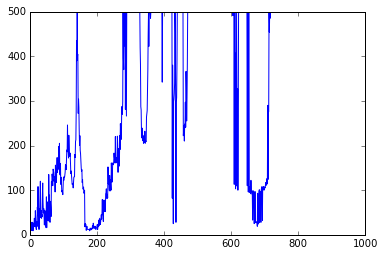

In [7]:
plt.plot(trainer.total_rewards)

array([ 0.59310051,  0.04232609,  0.00264757, -0.06203847])